Need to find an area covered by roughly 4 undithered FOVs for a full PhoSim simulation.

Want the area to have pixels with mean/typical depth= median survey depth. and not so scattered abs(max-min)depth.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import time
import pandas as pd
import lsst.sims.maf.metricBundles as metricBundles
from findDC1Regions import findDC1Regions

In [2]:
workDir= os.getcwd()

In [3]:
path= '/Volumes/Transcend/'
path2= '2017-01-11/coaddM5Analysis_nside256_withDustExtinction_14pixelRadiusForMasking_rBand_minion1016_fullSurveyPeriod_directory/'
path3= 'maskedCoaddData/'
os.chdir(path+path2+path3)

# get the saved files
filenames = ['coaddM5Data_masked_r_NoDither.npz', 
             'coaddM5Data_masked_r_SequentialHexDitherPerNight.npz']

coaddBundle= {}
for i in range(len(filenames)):
    mB = metricBundles.createEmptyMetricBundle()
    mB.read(filenames[i])
    dithStrategy= mB.metadata.strip()   # key is assigned to be the same as dithStrategy
    print 'Filename for ' + dithStrategy + ': ', filenames[i]
    print ''

    coaddBundle[dithStrategy]= mB

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Filename for NoDither:  coaddM5Data_masked_r_NoDither.npz

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Filename for SequentialHexDitherPerNight:  coaddM5Data_masked_r_SequentialHexDitherPerNight.npz



In [4]:
help(findDC1Regions)

Help on function findDC1Regions in module findDC1Regions:

findDC1Regions(coaddBundle, dbpath, plotTestPlots=True, filterBand='i', threshold=0.0001, nside=256, returnAll=False)
    Find candidate regions for DC1 (based on how wildly the average depth in the region 
    differs from the survey median depth).
    
    Returns a bunch of stuff ...
    
    Required Parameters
    -------------------
      * coaddBundle: dict: dictionary with keys= observing strategy names, pointing to corresponding
                           to a metricBundle object.
           NOTE: coaddBundle should have always have NoDither. If want to find regions based on a dithered
                 survey, the bundle should have the dithered data ALONG WITH the undithered one.
      * dbpath: str: path to the OpSim database.
    
    Optional Parameters
    -------------------
      * plotTestPlots: bool: set to False if dont want to plot things for debugging/testing code.
                             Default: True


############################################
## Getting RA, Dec for HEALPix pixels ...

############################################
## Getting simdata ...

############################################
## Getting pixels_in_FOV ...
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
Number of fieldIDs in pixel_in_FOV for SequentialHexDitherPerNight: 2249.000000

############################################
## Finding good regions ...

############################################
## Finding good regions with threshold= 0.000100 using SequentialHexDitherPerNight

## Mean survey depth for SequentialHexDitherPerNight: 27.008246

## Mean survey depth for SequentialHexDitherPerNight: 27.008246
Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes

############################################
## Plotting good regions with threshold= 0.000100 using SequentialHexDitherPerNig

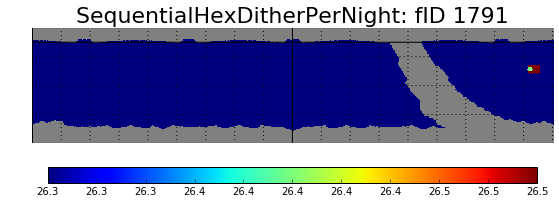

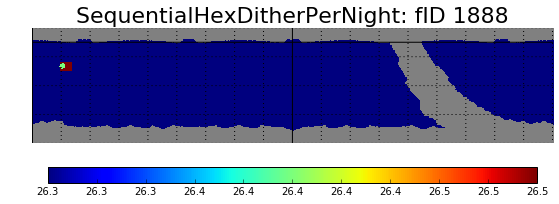


## Cicular regions (using plotRegion):


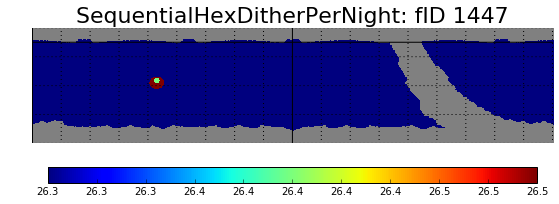

Time taken (s): 484.151417017


In [5]:
startTime= time.time()
dbpath = path+'minion_1016_sqlite.db'
output= findDC1Regions(coaddBundle, dbpath, plotTestPlots= False,
                       filterBand= 'r', returnAll= True)

focusDither, output_rect, output_disc, simdata, pixels_in_FOV, pixelNum, pixRA, pixDec= output

print 'Time taken (s):', time.time()-startTime

In [7]:
pd.DataFrame([output_rect['goodFiducialIDs'],output_rect['diffMeanMedian'],
             output_rect['scatterInDepth'], output_rect['fiducialRA'],
             output_rect['fiducialDec']], 
             ['goodFiducialIDs', 'DiffMeanMedian', 'DepthScatter', 'fiducialRA' , 'fiducialDec'])

,0,1
goodFiducialIDs,1.791000e+03,1888.000000
DiffMeanMedian,6.268360e-07,0.000032
DepthScatter,4.555302e-01,0.364538
fiducialRA,3.423892e+00,2.778955
fiducialDec,-3.314060e-01,-0.295396


^^ So we have 2 rectangular regions with the average depth within 0.0001 of the median survey depth.

In [8]:
pd.DataFrame([output_disc['goodFiducialIDs'],output_disc['diffMeanMedian'],
             output_disc['scatterInDepth'], output_disc['fiducialRA'],
             output_disc['fiducialDec'], output_disc['contigIDs']], 
             ['goodFiducialIDs', 'DiffMeanMedian', 'DepthScatter', 'fiducialRA' , 'fiducialDec',
             'contigIDs'])

,0
goodFiducialIDs,1447
DiffMeanMedian,8.51566e-05
DepthScatter,0.403503
fiducialRA,1.64132
fiducialDec,-0.496321
contigIDs,"[1447, 1323, 1431, 1333]"


^^ So we have only 1 circular region with the average depth within 0.0001 of the median survey depth.

### Check some things with the disc region.

In [11]:
os.chdir(workDir)
from intermediates import findRegionFOVs

In [12]:
help(findRegionFOVs)

Help on function findRegionFOVs in module intermediates:

findRegionFOVs(regionPixels, dither, simdata, nside=256)
    Find the FOVs that corresponds to any HEALPix pixels in the region.
    
    Required Parameters
    -------------------
    * regionPixels: array: array containing the HEALPIx pixel numbers in the region of interest.
    * dither: str: dither strategy to focus on.
    * simdata: np.array: array containing OpSim columns (must have fieldID for here).
    
    Optional Parameters
    -------------------
    * nside: int: HEALPix resolution parameters. Default: 256



In [15]:
findRegionFOVs(output_disc['regionPixels'][0], 'NoDither', simdata)

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes


array([1212, 1220, 1234, 1305, 1323, 1333, 1365, 1413, 1431, 1447, 1464,
       1506, 1542, 1564, 1568])

In [16]:
from plotFunctions import buildAndPlotRegion

In [17]:
help(buildAndPlotRegion)

Help on function buildAndPlotRegion in module plotFunctions:

buildAndPlotRegion(fID, simdata, coaddBundle, FOV_radius, pixels_in_FOV, focusDither=None, nside=256, disc=False)
    Find the region (disc or rectangular) based on the specified field ID and plot it (full survey
    region and a zoomed in version).
    
    Required Parameters
    -------------------
    * fID: int: fieldID for the FOV on which to base the region.
    * simdata: np.array: array containing OpSim columns (must have fieldID, fieldRA, fieldDec).
    * coaddBundle: dict: dictionary with keys= observing strategy names, pointing to corresponding
                         to a metricBundle object.
    * FOV_radius: float: radius of the FOV in radians.
    * pixels_in_FOV: dict: dictionary with keys= dither strategy. Each key points to a dictionary with
                           keys= field ID, pointing to the list of HEALPix pixels
                           that fall in the FOV.
    
    Optional Parameters
    --

In [19]:
focusDither

'SequentialHexDitherPerNight'

Healpix slicer using NSIDE=256, approximate resolution 13.741946 arcminutes
FID List for SequentialHexDitherPerNight: [1212, 1220, 1234, 1305, 1323, 1333, 1365, 1413, 1431, 1447, 1464, 1506, 1542, 1564, 1568]

## Grey (masked) pixel was inputted in the query_ function.


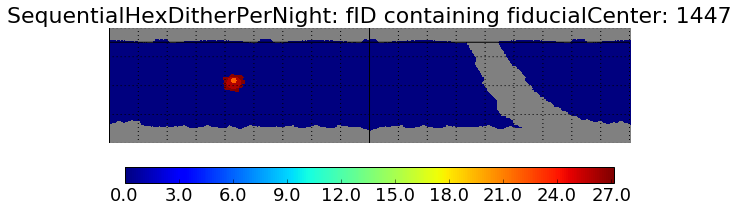

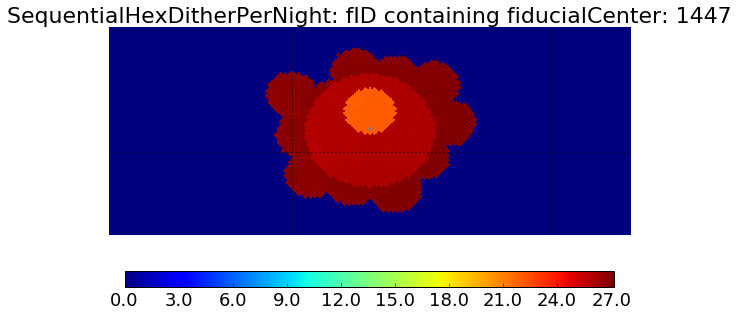

In [21]:
buildAndPlotRegion(output_disc['goodFiducialIDs'][0], simdata, coaddBundle, FOV_radius= 0.0305, 
                   pixels_in_FOV= pixels_in_FOV, 
                   focusDither= 'SequentialHexDitherPerNight', disc= True )